In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score


In [2]:
np.random.seed(42)

data = pd.DataFrame({
    "CustomerID": range(1,201),
    "Age": np.random.randint(18,60,200),
    "AnnualIncome": np.random.randint(20000,120000,200),
    "SpendingScore": np.random.randint(1,100,200),
    "PurchaseFrequency": np.random.randint(1,50,200),
    "AvgOrderValue": np.random.randint(10,500,200),
    "TimeOnApp": np.random.randint(1,120,200),
    "Gender": np.random.choice(["Male","Female"],200)
})

data.head()


,CustomerID,Age,AnnualIncome,SpendingScore,PurchaseFrequency,AvgOrderValue,TimeOnApp,Gender
0,1,56,45342,70,43,84,33,Male
1,2,46,57157,15,11,444,53,Female
2,3,32,87863,54,18,112,22,Female
3,4,25,72083,60,47,431,21,Male
4,5,38,85733,97,12,201,70,Male


In [3]:
df = data.copy()

# Remove ID
df = df.drop("CustomerID", axis=1)

# Convert categorical to numeric
df = pd.get_dummies(df, drop_first=True)

df.head()


,Age,AnnualIncome,SpendingScore,PurchaseFrequency,AvgOrderValue,TimeOnApp,Gender_Male
0,56,45342,70,43,84,33,True
1,46,57157,15,11,444,53,False
2,32,87863,54,18,112,22,False
3,25,72083,60,47,431,21,True
4,38,85733,97,12,201,70,True


In [4]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)


In [5]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_data, columns=["PC1","PC2"])

print("Explained variance:", pca.explained_variance_ratio_)
pca_df.head()


Explained variance: [0.17125163 0.16433706]


,PC1,PC2
0,-1.744089,1.025513
1,1.214071,0.169705
2,-0.340483,-0.548534
3,-0.018190,0.284972
4,-0.339495,0.366737


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

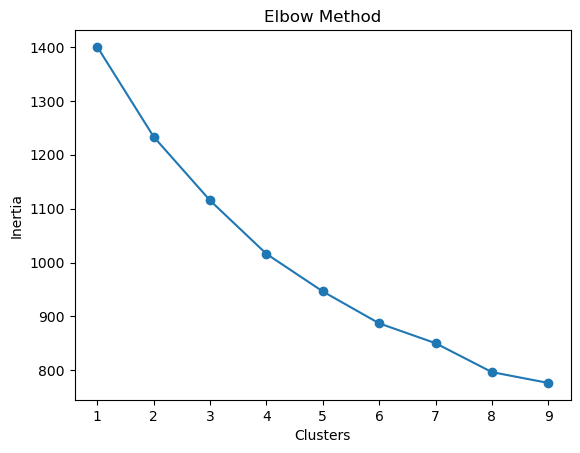

In [6]:
inertia = []

for i in range(1,10):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

plt.plot(range(1,10), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.show()


In [7]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

pca_df["KMeans"] = kmeans_labels


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [8]:
hc = AgglomerativeClustering(n_clusters=4)
hc_labels = hc.fit_predict(scaled_data)

pca_df["Hierarchical"] = hc_labels


In [9]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
db_labels = dbscan.fit_predict(scaled_data)

pca_df["DBSCAN"] = db_labels

print("Noise points detected:", list(db_labels).count(-1))


Noise points detected: 200


In [10]:
lda = LDA(n_components=2)
lda_data = lda.fit_transform(scaled_data, kmeans_labels)

lda_df = pd.DataFrame(lda_data, columns=["LD1","LD2"])
lda_df["Cluster"] = kmeans_labels
lda_df.head()


,LD1,LD2,Cluster
0,-2.878267,-1.280574,0
1,2.915539,0.575588,3
2,2.333276,0.417068,3
3,-1.895627,1.218242,1
4,-2.763816,0.483081,1


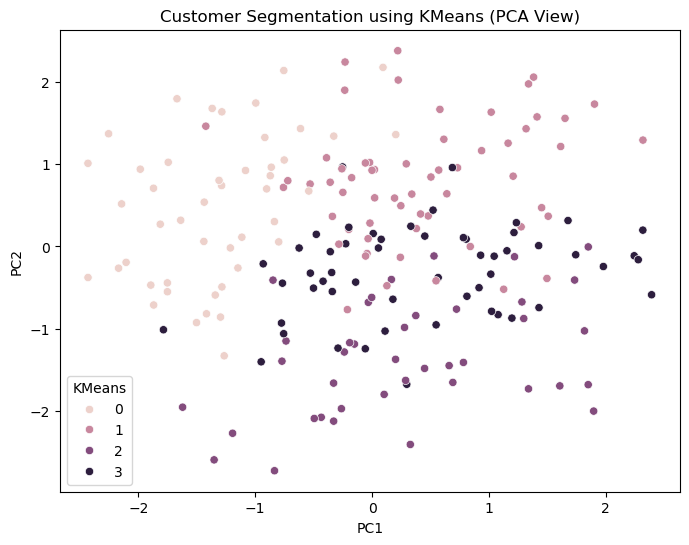

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue="KMeans", data=pca_df)
plt.title("Customer Segmentation using KMeans (PCA View)")
plt.show()


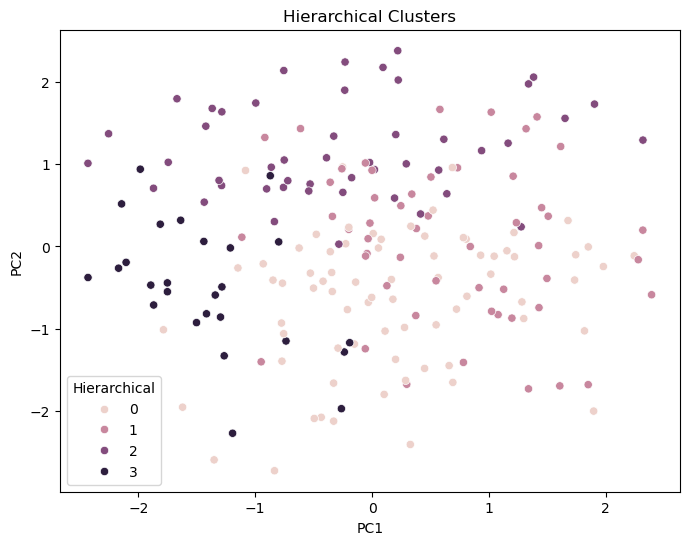

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue="Hierarchical", data=pca_df)
plt.title("Hierarchical Clusters")
plt.show()


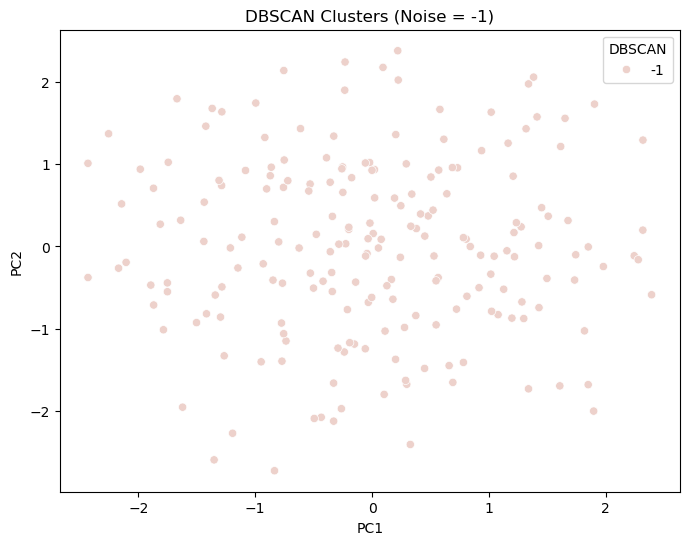

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", hue="DBSCAN", data=pca_df)
plt.title("DBSCAN Clusters (Noise = -1)")
plt.show()


In [14]:
score = silhouette_score(scaled_data, kmeans_labels)
print("Silhouette Score:", score)


Silhouette Score: 0.1261433512993444


In [17]:
# Add cluster labels to original dataset
data["Cluster"] = kmeans_labels

# Select only numeric columns (important to avoid errors)
numeric_data = data.select_dtypes(include=[np.number])

# Group by cluster and calculate mean values
cluster_summary = numeric_data.groupby("Cluster").mean()

# Display result
print(cluster_summary.round(2))


         CustomerID    Age  AnnualIncome  SpendingScore  PurchaseFrequency  \
Cluster                                                                      
0            112.80  41.24      42234.41          54.54              19.52   
1             99.42  39.45      89352.35          49.80              26.12   
2             91.55  32.98      54325.48          46.00              30.48   
3             97.85  39.81      75242.37          51.02              21.85   

         AvgOrderValue  TimeOnApp  
Cluster                            
0               141.76      36.26  
1               276.98      61.72  
2               200.15      91.05  
3               302.28      41.09  
